In [10]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("asm_full_opt")
from generate_waves import GenerateWaves
import config


In [11]:
gw = GenerateWaves(config)
x, y, X, Y = gw.build_spatial_grid()

print("x shape:", x.shape)
print("y shape:", y.shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

c = gw.grid_N // 2
print("Center (X,Y):", X[c, c].item(), Y[c, c].item())

print("x min/max:", x.min().item(), x.max().item())
print("y min/max:", y.min().item(), y.max().item())


x shape: torch.Size([257])
y shape: torch.Size([257])
X shape: torch.Size([257, 257])
Y shape: torch.Size([257, 257])
Center (X,Y): 0.0 0.0
x min/max: -4.479999915929511e-05 4.479999915929511e-05
y min/max: -4.479999915929511e-05 4.479999915929511e-05


In [12]:
uv_samples, pixel_to_sample = gw.sample_field_points(strategy="full")

print("uv_samples shape:", uv_samples.shape)          # [P,2]
print("pixel_to_sample shape:", pixel_to_sample.shape)  # [H,W]
print("num samples P:", uv_samples.shape[0])

# check a few pixels
H, W = pixel_to_sample.shape
for (v0, u0) in [(0,0), (3,5), (H-1, W-1)]:
    p = int(pixel_to_sample[v0, u0].item())
    print(f"(v,u)=({v0},{u0}) -> p={p}, uv_samples[p]={uv_samples[p].tolist()}")


uv_samples shape: torch.Size([784, 2])
pixel_to_sample shape: torch.Size([28, 28])
num samples P: 784
(v,u)=(0,0) -> p=0, uv_samples[p]=[0.5, 0.5]
(v,u)=(3,5) -> p=143, uv_samples[p]=[5.5, 3.5]
(v,u)=(27,27) -> p=783, uv_samples[p]=[27.5, 27.5]


In [13]:
uv_samples, pixel_to_sample = gw.sample_field_points(strategy="block")

print("uv_samples shape:", uv_samples.shape)          # [P,2]
print("pixel_to_sample shape:", pixel_to_sample.shape)  # [H,W]
print("num samples P:", uv_samples.shape[0])

# check a few pixels
H, W = pixel_to_sample.shape
for (v0, u0) in [(0,0), (3,5), (H-1, W-1)]:
    p = int(pixel_to_sample[v0, u0].item())
    print(f"(v,u)=({v0},{u0}) -> p={p}, uv_samples[p]={uv_samples[p].tolist()}")

uv_samples shape: torch.Size([49, 2])
pixel_to_sample shape: torch.Size([28, 28])
num samples P: 49
(v,u)=(0,0) -> p=0, uv_samples[p]=[2.0, 2.0]
(v,u)=(3,5) -> p=7, uv_samples[p]=[6.0, 2.0]
(v,u)=(27,27) -> p=48, uv_samples[p]=[26.0, 26.0]


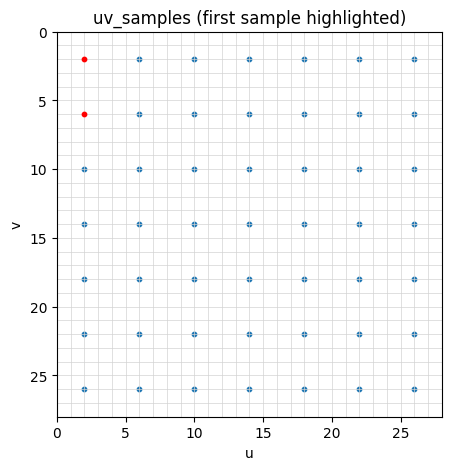

In [14]:
import matplotlib.pyplot as plt

uv = uv_samples.detach().cpu().numpy()
u = uv[:, 0]
v = uv[:, 1]

plt.figure(figsize=(5,5))

# draw grid
for k in range(W+1):
    plt.plot([k, k], [0, H], linewidth=0.5, color="lightgray")
for k in range(H+1):
    plt.plot([0, W], [k, k], linewidth=0.5, color="lightgray")

# all points except first
plt.scatter(u[2:], v[2:], s=10)

# first two points in red
plt.scatter(u[0:2], v[0:2], s=10, color="red", zorder=3)

plt.xlim(0, W)
plt.ylim(H, 0)
plt.gca().set_aspect("equal")
plt.title("uv_samples (first sample highlighted)")
plt.xlabel("u")
plt.ylabel("v")
plt.show()



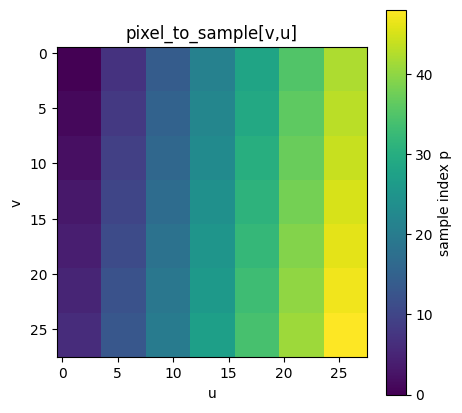

In [15]:
pts = pixel_to_sample.detach().cpu().numpy()

plt.figure(figsize=(5,5))
plt.imshow(pts, interpolation="nearest")
plt.title("pixel_to_sample[v,u]")
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar(label="sample index p")
plt.show()


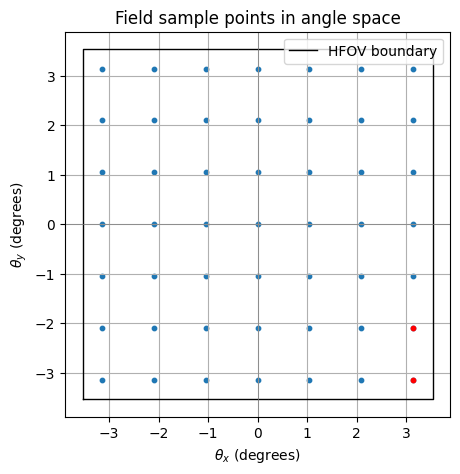

In [16]:
# Compute angles
theta_x, theta_y = gw.uv_to_angles(uv_samples)

# Convert to degrees for visualization
tx = theta_x.detach().cpu().numpy() * 180 / math.pi
ty = theta_y.detach().cpu().numpy() * 180 / math.pi

plt.figure(figsize=(5,5))

hfov = gw.hfov  # degrees
a = hfov / np.sqrt(2)  # half-width in degrees
plt.plot([-a,  a,  a, -a, -a],
         [-a, -a,  a,  a, -a],
         linewidth=1, color="black", label="HFOV boundary")
    

plt.scatter(tx, ty, s=10)

# Highlight the first sample (p=0) in red
plt.scatter(tx[0:2], ty[0:2], s=10, color="red", zorder=3)

plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)

plt.xlabel(r"$\theta_x$ (degrees)")
plt.ylabel(r"$\theta_y$ (degrees)")
plt.title("Field sample points in angle space")
plt.legend()

plt.gca().set_aspect("equal")
plt.grid(True)




plt.show()


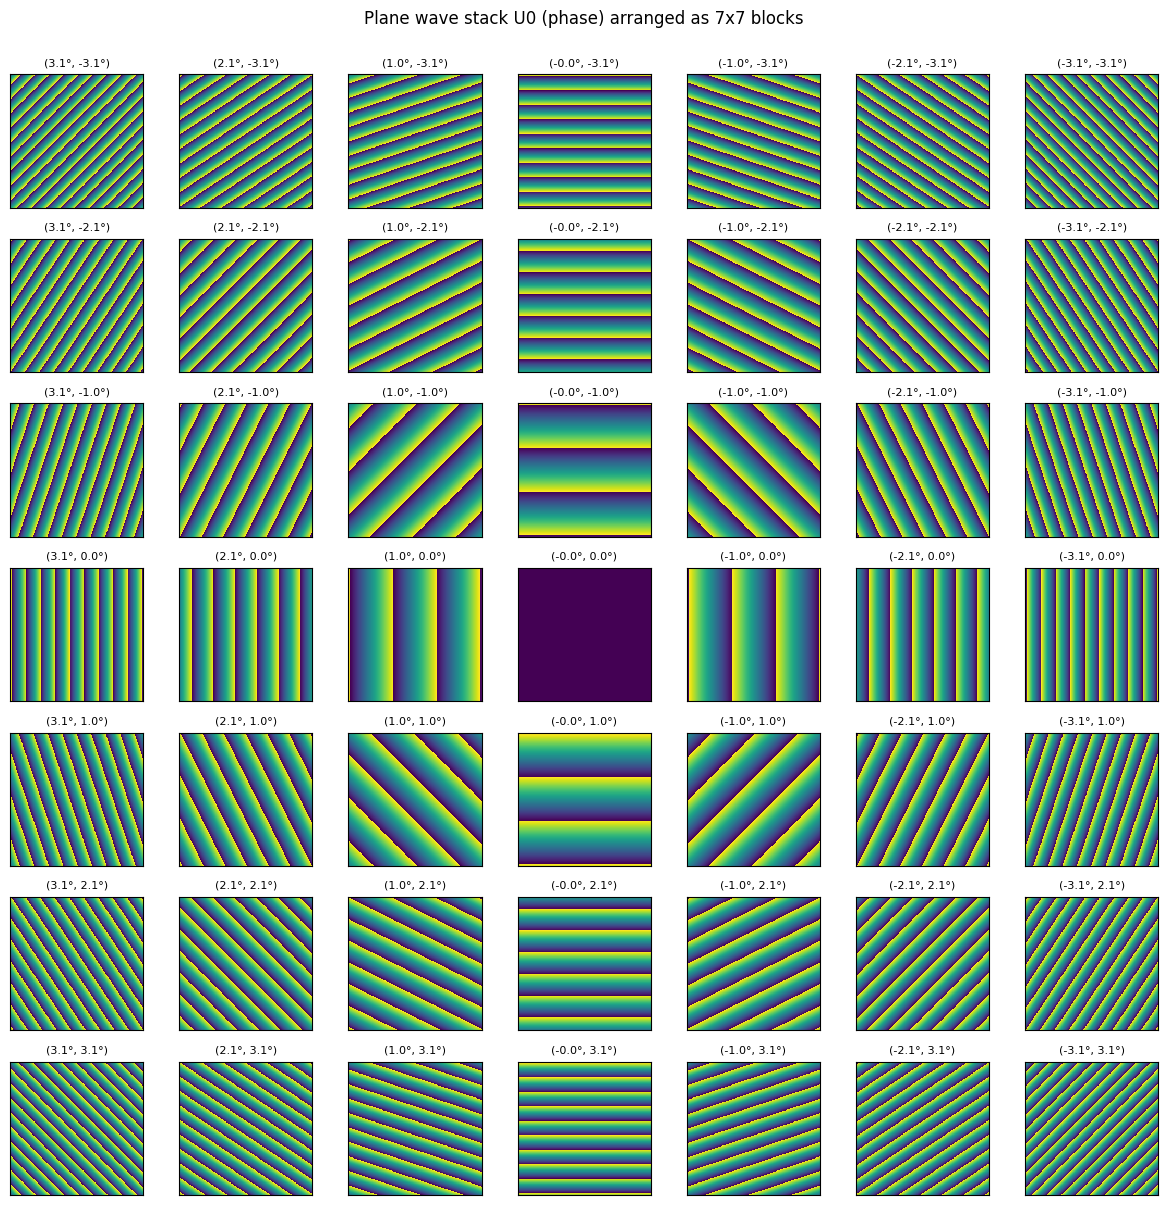

In [17]:
gw.generate_plane_wave_stack(strategy="block", block_size=4)
U0 = gw.U0

P, N, _ = U0.shape
nBW = gw.nBW
nBH = gw.nBH
assert P == nBW * nBH, (P, nBW, nBH)

# Reshape into [nBW, nBH, N, N] because your indexing is u-major (block_u first)
U0_grid = U0.reshape(nBW, nBH, N, N)

# Choose what to visualize: phase / amplitude / intensity
mode = "phase"   # "amp" or "intensity"

fig, axes = plt.subplots(nBH, nBW, figsize=(12, 12))

for bi in range(nBH):          # block_v (rows)
    for bj in range(nBW):      # block_u (cols)
        ax = axes[bi, bj]

        field = U0_grid[bj, bi]   # NOTE: [block_u, block_v] due to u-major ordering

        if mode == "phase":
            img = torch.angle(field).detach().cpu().numpy()
        elif mode == "amp":
            img = torch.abs(field).detach().cpu().numpy()
        elif mode == "intensity":
            img = (torch.abs(field)**2).detach().cpu().numpy()
        else:
            raise ValueError("mode must be 'phase', 'amp', or 'intensity'")

        ax.imshow(img.T, interpolation="nearest", origin="lower")
        ax.set_xticks([])
        ax.set_yticks([])

        # optional: label with (theta_x, theta_y) in degrees
        tx = float(theta_x[bj * nBH + bi].detach().cpu().numpy() * 180/np.pi)
        ty = float(theta_y[bj * nBH + bi].detach().cpu().numpy() * 180/np.pi)
        ax.set_title(f"({tx:.1f}°, {ty:.1f}°)", fontsize=8)

plt.suptitle(f"Plane wave stack U0 ({mode}) arranged as {nBH}x{nBW} blocks", y=1)
plt.tight_layout()
plt.show()


In [18]:
print(U0.shape)

torch.Size([49, 257, 257])
